# Introduction

Hello, I'm Wesley, nice to meet you! 👋

There are in general two types of deep learning models - **discriminative** and **generative** models. 

An example of a **discriminative** model in NLP is a **text classification model** like my previous notebook *[Twitter Emotion Classification with BERT](https://www.kaggle.com/code/wesleyacheng/twitter-emotion-classification-with-bert)* where we classified each tweet into one of three emotions - joy, anger, and sadness.
On the other hand, an example of a **generative** model in NLP is an **autoregressive text model** like the recently mainstream **ChatGPT** where it predicts/generates its next words based on the input sentence you provide it with.


Here's an example of what a **generative** NLP model can do.

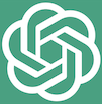

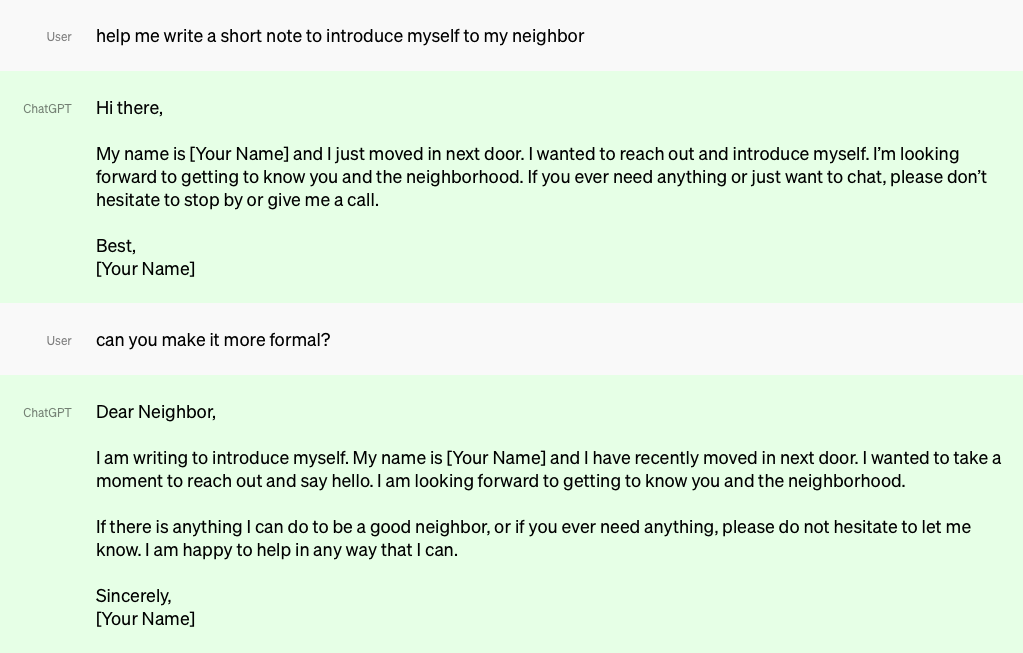

Here's the link to their [blog post](https://openai.com/blog/chatgpt) if you want to know more about **ChatGPT** and how it was fine-tuned from GPT-3.5 with reinforcement learning.

The **main difference** between a **discriminative** model and a **generative** model is that **discriminative** models *predict where a new unknown data point might fit in its data distribution based the dataset it was trained on*, hence it outputs a class/category; while a **generative** model *uses the new unknown data point as a starting point to predict/generate new data points that are highly related to it*, hence it outputs similar content that is highly related to the input it was given.
 
These two types of models are different as they tackle different problems. **Discriminative** models tackle the problem of *how to split the dataset into clusters with similar features*, while **generative** models tackle the *problem of how to use the dataset to make new data that are highly similar to it*.

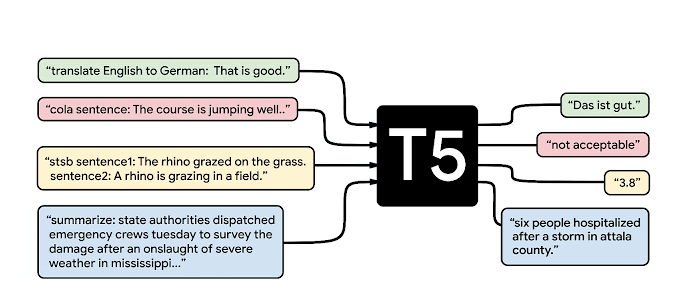

As an introduction to **generative** models in **Natural Language Processing (NLP)** in this notebook, we will be doing the **classic machine translation task** (a **generative** problem) of translating **English to French** by transfer learning with **Google's T5 model** [\[blog\]](https://ai.googleblog.com/2020/02/exploring-transfer-learning-with-t5.html). We will be using the *HuggingFace NLP interface* to simplify this introduction. Let's get going! 🦾

# Setup Libraries

In [1]:
%%bash
pip install numpy torch datasets transformers~=4.28.0 evaluate torchinfo sacrebleu --quiet
pip freeze | grep -E '^numpy|^torch|^datasets|^transformers|^evaluate|^torchinfo|^sacrebleu'

datasets==2.1.0
evaluate==0.4.0
numpy==1.23.5
sacrebleu==2.3.1
torch @ file:///tmp/torch/torch-2.0.0-cp310-cp310-linux_x86_64.whl#sha256=de0c947f8c06a637392b3efa76aad3ac1d91effd6481f8154aeeb4303f12d133
torchaudio @ file:///tmp/torch/torchaudio-2.0.1-cp310-cp310-linux_x86_64.whl#sha256=178c0fd167dd56970d14aa26ff4e98d8963ead026f00b4f36d6d7fc93421f317
torchdata==0.6.0
torchinfo==1.8.0
torchmetrics==1.0.0
torchtext @ file:///tmp/torch/torchtext-0.15.1-cp310-cp310-linux_x86_64.whl#sha256=89c1e3cb8aa36dc34a82501799a7d364ca4a4f6d447d86324a9aec7036fa4702
torchvision @ file:///tmp/torch/torchvision-0.15.1-cp310-cp310-linux_x86_64.whl#sha256=4ed53c3d788b3394127da0e3207891e604d52f3b7ea69e5be0a895cc6029ed4a
transformers==4.28.1


# Create Dataset

## Set Seed

In [2]:
# set seed for reproducibility

import torch
import numpy as np

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

## Clone Raw Dataset

In [3]:
# we will be using a smaller version of the OPUS-100 dataset to speed up training

from datasets import load_dataset

raw_datasets = load_dataset('opus_books', 'en-fr')

Generating train split:   0%|          | 0/127085 [00:00<?, ? examples/s]

Dataset opus_books downloaded and prepared to /root/.cache/huggingface/datasets/opus_books/en-fr/1.0.0/e8f950a4f32dc39b7f9088908216cd2d7e21ac35f893d04d39eb594746af2daf. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
# let's see some info of the dataset

display(raw_datasets)

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 127085
    })
})

In [5]:
# let's see an example of the dataset

# we see that we have an unique 'id' for each data point and 
# a dictionary called 'translation' with the english in the 'en' key and french in the 'fr' key.
raw_datasets['train'][0]

{'id': '0', 'translation': {'en': 'The Wanderer', 'fr': 'Le grand Meaulnes'}}

## Split Dataset

In [6]:
# split dataset with seed and shuffling

from datasets import DatasetDict

train_val_datasets = raw_datasets['train'].train_test_split(test_size=0.1, seed=SEED, shuffle=True)
val_test_datasets = train_val_datasets['test'].train_test_split(test_size=0.5, seed=SEED, shuffle=True)
split_datasets = DatasetDict({
    'train': train_val_datasets['train'],
    'validation': val_test_datasets['train'],
    'test': val_test_datasets['test'],
})

# display the split
split_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 114376
    })
    validation: Dataset({
        features: ['id', 'translation'],
        num_rows: 6354
    })
    test: Dataset({
        features: ['id', 'translation'],
        num_rows: 6355
    })
})

## Exploratory Data Analysis

In [7]:
# let's get the number of words in the dataset

english_word_counts = []
french_word_counts = []

for split_type in split_datasets:
    for example in split_datasets[split_type]:
        english_word_counts.append(len(example['translation']['en'].split(' ')))
        french_word_counts.append(len(example['translation']['fr'].split(' ')))
        
print(f"MIN ENGLISH WORD COUNT: {min(english_word_counts)}")
print(f"MAX ENGLISH WORD COUNT: {max(english_word_counts)}")
print(f"MEAN ENGLISH WORD COUNT: {sum(english_word_counts)/len(english_word_counts)}")

print(f"MIN FRENCH WORD COUNT: {min(french_word_counts)}")
print(f"MAX FRENCH WORD COUNT: {max(french_word_counts)}")
print(f"MEAN FRENCH WORD COUNT: {sum(french_word_counts)/len(french_word_counts)}")

MIN ENGLISH WORD COUNT: 1
MAX ENGLISH WORD COUNT: 372
MEAN ENGLISH WORD COUNT: 21.364212928355037
MIN FRENCH WORD COUNT: 1
MAX FRENCH WORD COUNT: 324
MEAN FRENCH WORD COUNT: 20.79159617578786


## Tokenize Dataset

In [8]:
# we will be using the smallest Google T5 model to speed up the process

from transformers import AutoTokenizer

CHECKPOINT = 't5-small'
tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT)

In [9]:
# let's tokenize the dataset

# get languages of dataset
source_language, target_language = raw_datasets['train'].features['translation'].languages
print(f"SOURCE LANGUAGE: {source_language} (English)")
print(f"TARGET LANGUAGE: {target_language} (French)")

# T5 requires a prompt to train on
t5_translation_prompt = 'translate English to French:'
def tokenize_function(batch):
    # we add the prompt in front of all the English text inputs
    source_inputs = [f"{t5_translation_prompt} {example[source_language]}" for example in batch['translation']]
    # we get all the French text outputs
    target_outputs = [example[target_language] for example in batch['translation']]
    # we tokenize with truncation and cap max length 512 given the max length of french is 324 to speed up training
    return tokenizer(source_inputs, text_target=target_outputs, max_length=512, truncation=True)

# tokenize dataset in batch for speed
tokenized_datasets = split_datasets.map(tokenize_function, batched=True, remove_columns=raw_datasets['train'].column_names)
tokenized_datasets

SOURCE LANGUAGE: en (English)
TARGET LANGUAGE: fr (French)


  0%|          | 0/115 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 114376
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 6354
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 6355
    })
})

# Setup Training

## Clone Model

In [23]:
# let's clone a small pre-trained t5 model

from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(CHECKPOINT)

In [24]:
# let's checkout the model architecture

from torchinfo import summary

summary(model)

Layer (type:depth-idx)                                  Param #
T5ForConditionalGeneration                              --
├─Embedding: 1-1                                        16,449,536
├─T5Stack: 1-2                                          16,449,536
│    └─Embedding: 2-1                                   (recursive)
│    └─ModuleList: 2-2                                  --
│    │    └─T5Block: 3-1                                3,147,008
│    │    └─T5Block: 3-2                                3,146,752
│    │    └─T5Block: 3-3                                3,146,752
│    │    └─T5Block: 3-4                                3,146,752
│    │    └─T5Block: 3-5                                3,146,752
│    │    └─T5Block: 3-6                                3,146,752
│    └─T5LayerNorm: 2-3                                 512
│    └─Dropout: 2-4                                     --
├─T5Stack: 1-3                                          16,449,536
│    └─Embedding: 2-5             

## Setup Data Collator

In [25]:
# setup data collator designed for seq2seq models like t5

from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer)

## Setup Training Metrics

In [26]:
import evaluate
import numpy as np

# import metric
bleu_metric = evaluate.load('bleu')

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    
    # decode predicted sentence and skip special tokens
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    # add padding (-100 = invalid token) and decode predicted target labels
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # postprocess for bleu metric
    post_decoded_preds = [pred.strip() for pred in decoded_preds]
    post_decoded_labels = [[label.strip()] for label in decoded_labels]
    
    # compute blue score
    result = bleu_metric.compute(predictions=post_decoded_preds, references=post_decoded_labels)
    
    return {'bleu': result['bleu']}

## Setup Trainer

In [27]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

# we setup training configuration
# 1. we add seed for reproducibility
# 2. we add output to results local directory
# 3. we add future-proofed AdamW optimizer
# 4. we train for 3 epochs
# 5. we train in 16 batch sizes
# 6. we evaluate per epoch
# 7. we load the best model based on lowest validation loss
# 8. we disable logging with report_to none
# 9. we enable fp16 precision to speed up run
training_args = Seq2SeqTrainingArguments(
    seed=SEED,
    output_dir='results',
    optim='adamw_torch',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    save_strategy='epoch',
    evaluation_strategy='epoch',
    load_best_model_at_end=True,
    report_to='none',
    fp16=True,
    predict_with_generate=True,
)

# we setup trainer with all previous variables
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Train Model

In [28]:
# let's get the unfine-tuned performance on the test set

trainer.evaluate(tokenized_datasets['test'])

{'eval_loss': 2.1427016258239746,
 'eval_bleu': 0.03824929014537052,
 'eval_runtime': 95.4041,
 'eval_samples_per_second': 66.611,
 'eval_steps_per_second': 4.172}

In [29]:
# let's train the model on the dataset

trainer.train()

Epoch,Training Loss,Validation Loss,Bleu
1,1.753500,1.533547,0.054957
2,1.698200,1.487897,0.057415
3,1.663100,1.475610,0.058191


TrainOutput(global_step=21447, training_loss=1.7417265333128613, metrics={'train_runtime': 4070.6298, 'train_samples_per_second': 84.294, 'train_steps_per_second': 5.269, 'total_flos': 9084615411105792.0, 'train_loss': 1.7417265333128613, 'epoch': 3.0})

In [30]:
# let's get the lowest validation loss model

trainer.evaluate()

{'eval_loss': 1.4756102561950684,
 'eval_bleu': 0.058191343265366485,
 'eval_runtime': 96.7772,
 'eval_samples_per_second': 65.656,
 'eval_steps_per_second': 4.113,
 'epoch': 3.0}

In [31]:
# let's see the performance of the fine-tuned performance on the test dataset

trainer.evaluate(tokenized_datasets['test'])

{'eval_loss': 1.4694230556488037,
 'eval_bleu': 0.061256261846268374,
 'eval_runtime': 97.1145,
 'eval_samples_per_second': 65.438,
 'eval_steps_per_second': 4.098,
 'epoch': 3.0}

# Let's try out some examples

In [32]:
# setup english to french translator pipeline

from transformers import pipeline

translator = pipeline('translation_en_to_fr', model=model.to('cpu'), tokenizer=tokenizer)

In [33]:
text = "translate English to French: I like this machine learning notebook."
translator(text)

[{'translation_text': "Je veux ce carnet d'apprentissage de machine."}]

In [34]:
text = "translate English to French: I don't know how to speak French."
translator(text)

[{'translation_text': 'Je ne sais pas comment parler français.'}]